![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/5.4.Pdf_Deidentification.ipynb)

# Setup

In [ ]:
import json, os
from google.colab import files

if 'spark_jsl.json' not in os.listdir():
  license_keys = files.upload()
  os.rename(list(license_keys.keys())[0], 'spark_ocr.json')

with open('spark_ocr.json') as f:
    license_keys = json.load(f)

# Defining license key-value pairs as local variables
locals().update(license_keys)

In [ ]:
license_keys.keys()

dict_keys(['SPARK_NLP_LICENSE', 'SECRET', 'JSL_VERSION', 'SPARK_OCR_LICENSE', 'SPARK_OCR_SECRET', 'OCR_VERSION', 'PUBLIC_VERSION', 'AWS_ACCESS_KEY_ID', 'AWS_SECRET_ACCESS_KEY'])

In [ ]:
# Installing Spark OCR
! pip install --upgrade -q spark-ocr==$OCR_VERSION --extra-index-url=https://pypi.johnsnowlabs.com/$SPARK_OCR_SECRET

# Installing pyspark and spark-nlp
! pip install --upgrade -q pyspark==3.4.1 spark-nlp==$PUBLIC_VERSION

# Installing Spark NLP Healthcare
! pip install --upgrade -q spark-nlp-jsl==$JSL_VERSION  --extra-index-url https://pypi.johnsnowlabs.com/$SECRET

<b><h1><font color='darkred'>!!! ATTENTION !!! </font><h1><b>

<b>After running previous cell, <font color='darkred'>RESTART the COLAB RUNTIME </font> and go ahead.<b>

In [1]:
import json, os

with open("spark_ocr.json", 'r') as f:
  license_keys = json.load(f)

# Adding license key-value pairs to environment variables
os.environ.update(license_keys)

# Defining license key-value pairs as local variables
locals().update(license_keys)

In [2]:
import sys
import os
import base64
import pkg_resources
import pandas as pd
import xml.etree.ElementTree as ET
from lxml import etree
import matplotlib.pyplot as plt
from IPython.display import Image
from PIL import Image, ImageFont, ImageDraw, ImageEnhance
import re

import sparknlp
import sparknlp_jsl

from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp_jsl.annotator import *

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml import Pipeline, PipelineModel

import sparkocr
from sparkocr import start
from sparkocr.enums import *
from sparkocr.utils import display_images
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import display_image, display_images, to_pil_image, display_pdf
from sparkocr.metrics import score

spark = sparkocr.start(secret=SPARK_OCR_SECRET,
                       nlp_version=PUBLIC_VERSION,
                       nlp_secret=SECRET,
                       nlp_internal=JSL_VERSION
                       )
spark

Spark version: 3.4.1
Spark NLP version: 5.3.2
Spark NLP for Healthcare version: 5.3.3
Spark OCR version: 5.3.2



## Define de-identification  NLP pipeline

In [3]:
def deidentification_nlp_pipeline(input_column, prefix = "", model="ner_deid_large"):
    document_assembler = DocumentAssembler() \
        .setInputCol(input_column) \
        .setOutputCol(prefix + "document_raw")

    cleanUpPatterns = ["<[^>]>"]
    documentNormalizer = DocumentNormalizer() \
        .setInputCols(prefix + "document_raw") \
        .setOutputCol(prefix + "document") \
        .setAction("clean") \
        .setPatterns(cleanUpPatterns) \
        .setReplacement(" ") \
        .setPolicy("pretty_all")

    # Sentence Detector annotator, processes various sentences per line
    sentence_detector = SentenceDetector() \
        .setInputCols([prefix + "document"]) \
        .setOutputCol(prefix + "sentence")

    tokenizer = Tokenizer() \
        .setInputCols([prefix + "sentence"]) \
        .setOutputCol(prefix + "token")

    # Clinical word embeddings
    word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models") \
        .setInputCols([prefix + "sentence", prefix + "token"]) \
        .setOutputCol(prefix + "embeddings") \
        .setEnableInMemoryStorage(True)

    clinical_ner = MedicalNerModel.pretrained(model, "en", "clinical/models") \
        .setInputCols([prefix + "sentence", prefix + "token", prefix + "embeddings"]) \
        .setOutputCol(prefix + "ner")

    custom_ner_converter = NerConverterInternal() \
        .setInputCols([prefix + "sentence", prefix + "token", prefix + "ner"]) \
        .setOutputCol(prefix + "ner_chunk") \
        .setWhiteList(['NAME', 'AGE', 'CONTACT', 'ID',
                   'LOCATION', 'PROFESSION', 'PERSON', 'DATE', 'DOCTOR'])

    nlp_pipeline = Pipeline(stages=[
        document_assembler,
        documentNormalizer,
        sentence_detector,
        tokenizer,
        word_embeddings,
        clinical_ner,
        custom_ner_converter
        ])
    empty_data = spark.createDataFrame([[""]]).toDF(input_column)
    nlp_model = nlp_pipeline.fit(empty_data)
    return nlp_model

## Define OCR transformers and pipeline for image deidentification

In [4]:
pdf_to_image = PdfToImage() \
    .setInputCol("content") \
    .setOutputCol("image") \
    .setPartitionNum(16)\
    .setSplitNumBatch(2)\
    .setPartitionNumAfterSplit(2) \
    .setSplittingStategy(SplittingStrategy.FIXED_NUMBER_OF_PARTITIONS) \
    .setKeepInput(False) \

ocr = ImageToText() \
    .setInputCol("image") \
    .setOutputCol("text") \
    .setIgnoreResolution(False) \
    .setPageIteratorLevel(PageIteratorLevel.SYMBOL) \
    .setPageSegMode(PageSegmentationMode.SPARSE_TEXT) \
    .setConfidenceThreshold(70) \


# Found coordinates of sensitive data
position_finder = PositionFinder() \
    .setInputCols(["ner_chunk"]) \
    .setOutputCol("regions") \
    .setPageMatrixCol("positions") \
    .setIgnoreSchema(True) \
    .setOcrScaleFactor(1.0)

#Draw filled rectangle for hide sensitive data
draw_regions = ImageDrawRegions() \
    .setInputCol("image") \
    .setInputRegionsCol("regions") \
    .setOutputCol("cleaned_images") \
    .setFilledRect(True) \
    .setRotated(False)

image_to_pdf = ImageToPdf() \
    .setInputCol("cleaned_images") \
    .setOutputCol("pdf")

# OCR pipeline
pipeline = PipelineModel(stages=[
    pdf_to_image,
    ocr,
    deidentification_nlp_pipeline(input_column="text", prefix="", model="ner_deid_generic_augmented"),
    position_finder,
    draw_regions
])

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_deid_generic_augmented download started this may take some time.
[OK!]


## Read PDF file and display it

Optimized for multipage PDF processing

In [5]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Healthcare/data/ocr/MT_00_compressed.pdf -P /content/deid/


    Image #0:
    Origin: file:/content/deid/MT_00_compressed.pdf
    Resolution: 100 dpi
    Width: 750 px
    Height: 1083 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


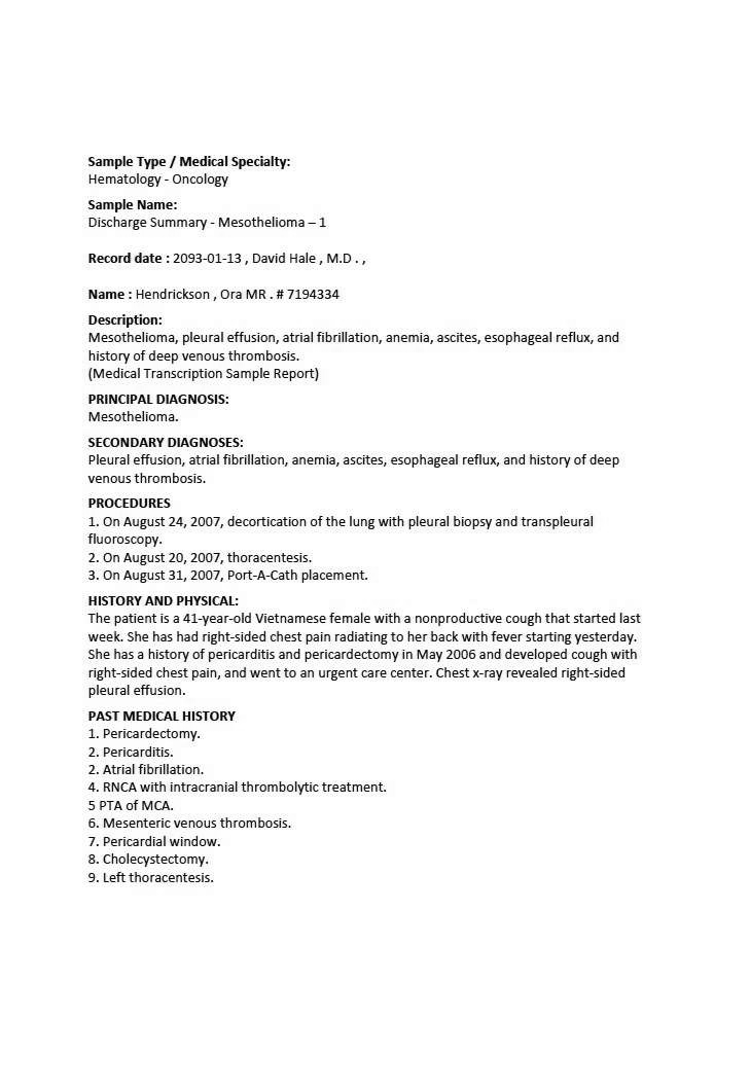


    Image #1:
    Origin: file:/content/deid/MT_00_compressed.pdf
    Resolution: 100 dpi
    Width: 750 px
    Height: 1083 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


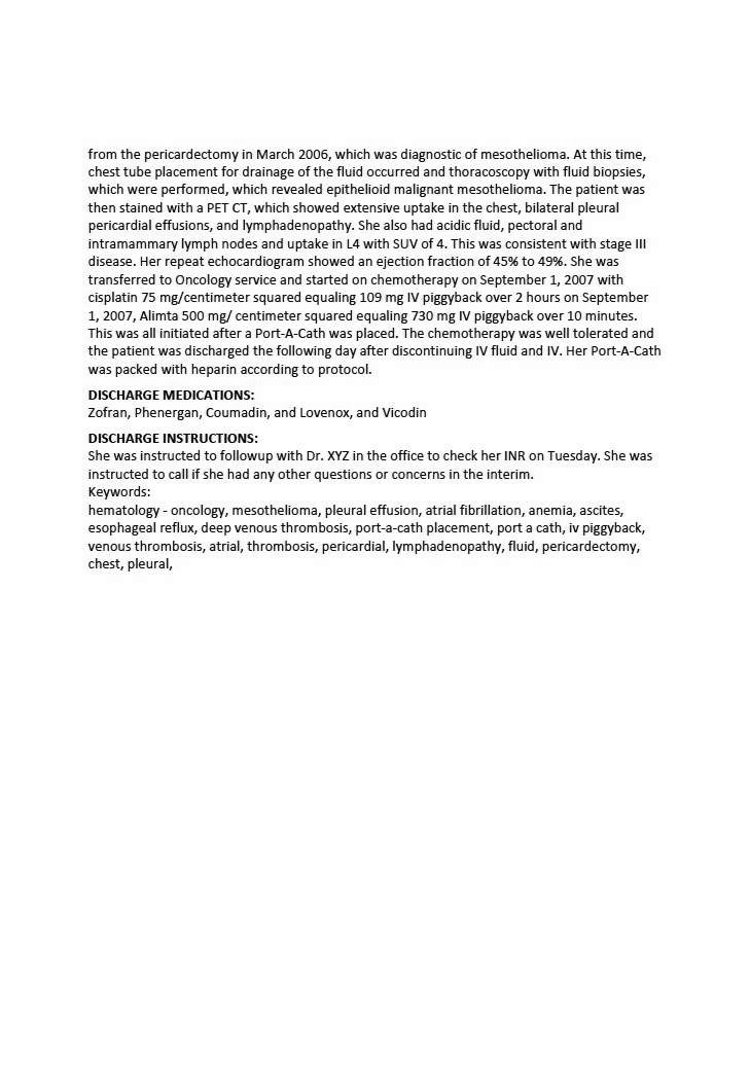


    Image #2:
    Origin: file:/content/deid/MT_00_compressed.pdf
    Resolution: 100 dpi
    Width: 750 px
    Height: 1083 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


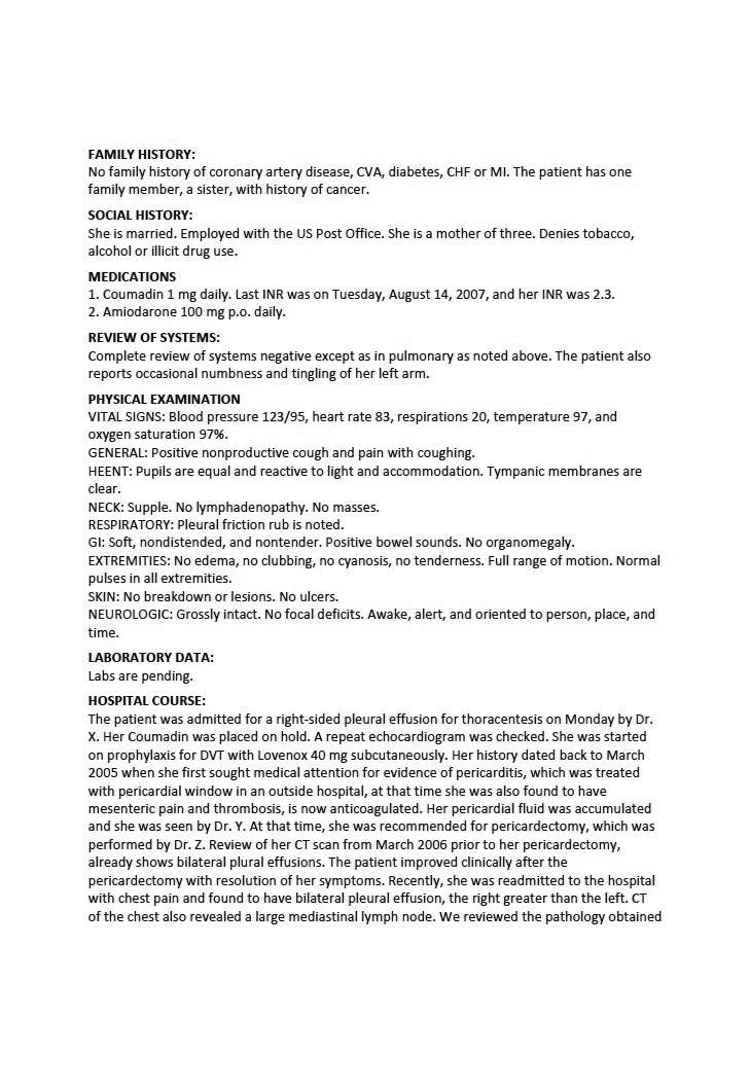

In [6]:
file_path='/content/deid/*.pdf'
pdf_df = spark.read.format("binaryFile").load(file_path)
display_images(pdf_to_image.setResolution(100).transform(pdf_df))

## Run de-id pipeline

In [7]:
from pyspark.sql.types import StringType

In [8]:
%%time

OUTPUT_PATH = "./de-id/"

def get_name(path, keep_subfolder_level=0):
    path = path.split("/")
    path[-1] = ".".join(path[-1].split('.')[:-1])
    return "/".join(path[-keep_subfolder_level-1:])


pages = pipeline.transform(pdf_df) \
    .cache() \
    .orderBy("pagenum")

image_to_pdf.transform(pages) \
    .withColumn("fileName", F.udf(get_name, StringType())(F.col("path"))) \
    .write \
    .format("binaryFormat") \
    .option("type", "pdf") \
    .option("field", "pdf") \
    .option("nameField", "fileName") \
    .option("extension", "pdf") \
    .option("prefix", "") \
    .mode("append") \
    .save(OUTPUT_PATH)

CPU times: user 430 ms, sys: 61.1 ms, total: 492 ms
Wall time: 39 s


## Check results

In [9]:
%%bash
ls ./de-id

MT_00_compressed.pdf
_SUCCESS



    Image #0:
    Origin: file:/content/de-id/MT_00_compressed.pdf
    Resolution: 100 dpi
    Width: 1041 px
    Height: 1504 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


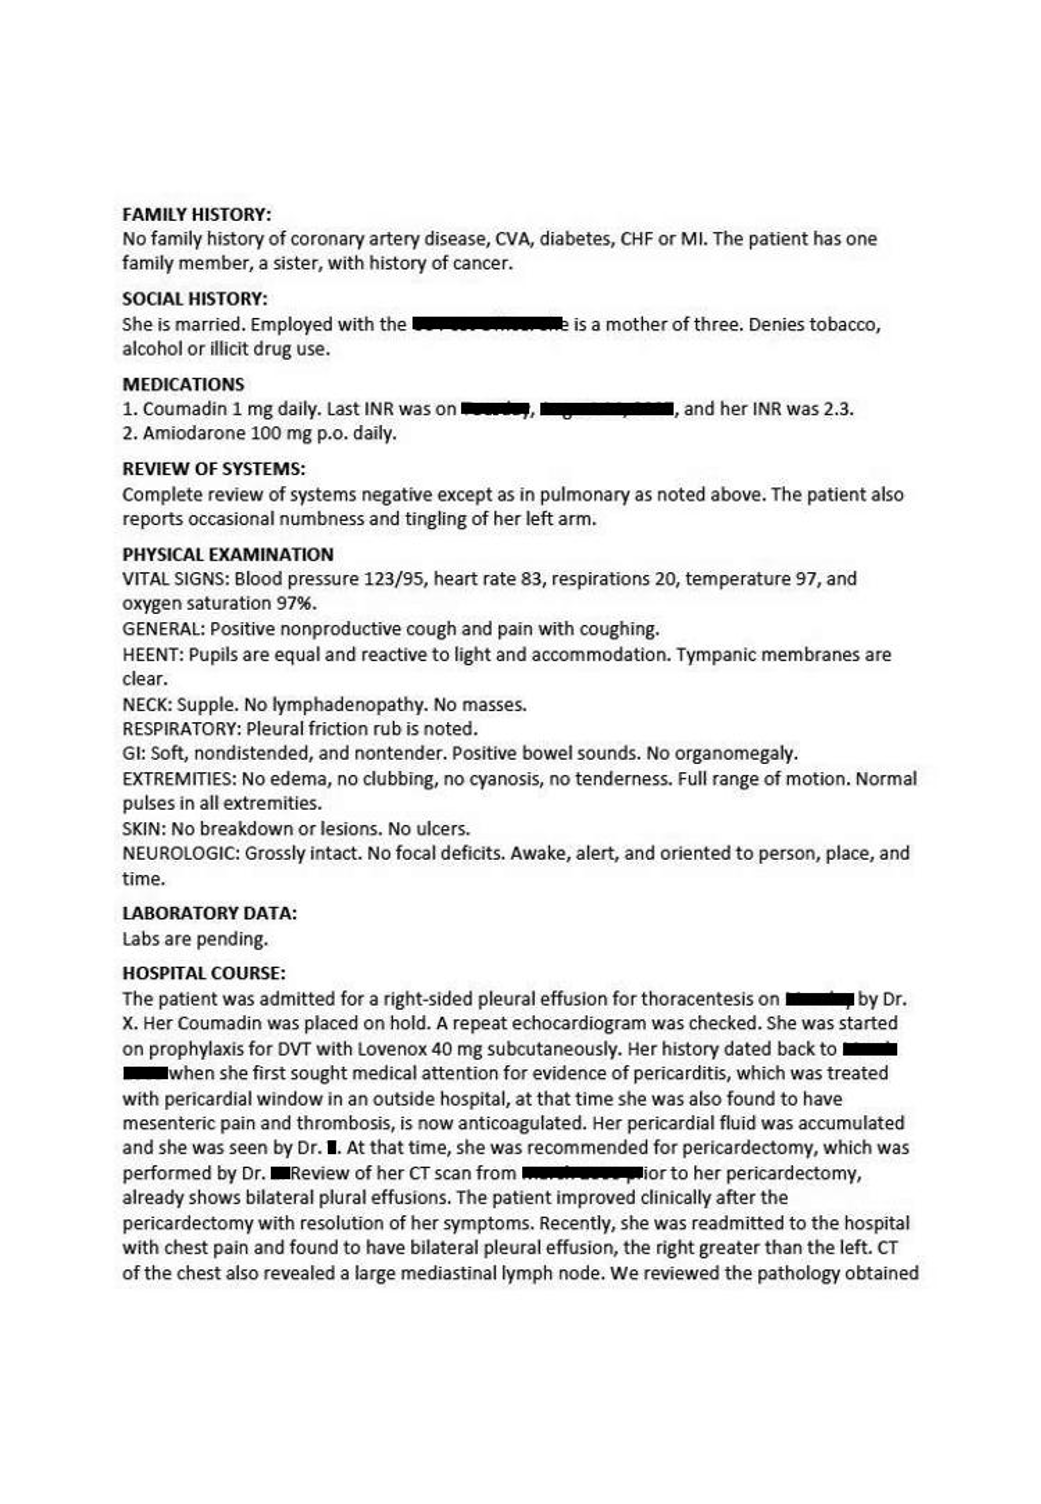


    Image #1:
    Origin: file:/content/de-id/MT_00_compressed.pdf
    Resolution: 100 dpi
    Width: 1041 px
    Height: 1504 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


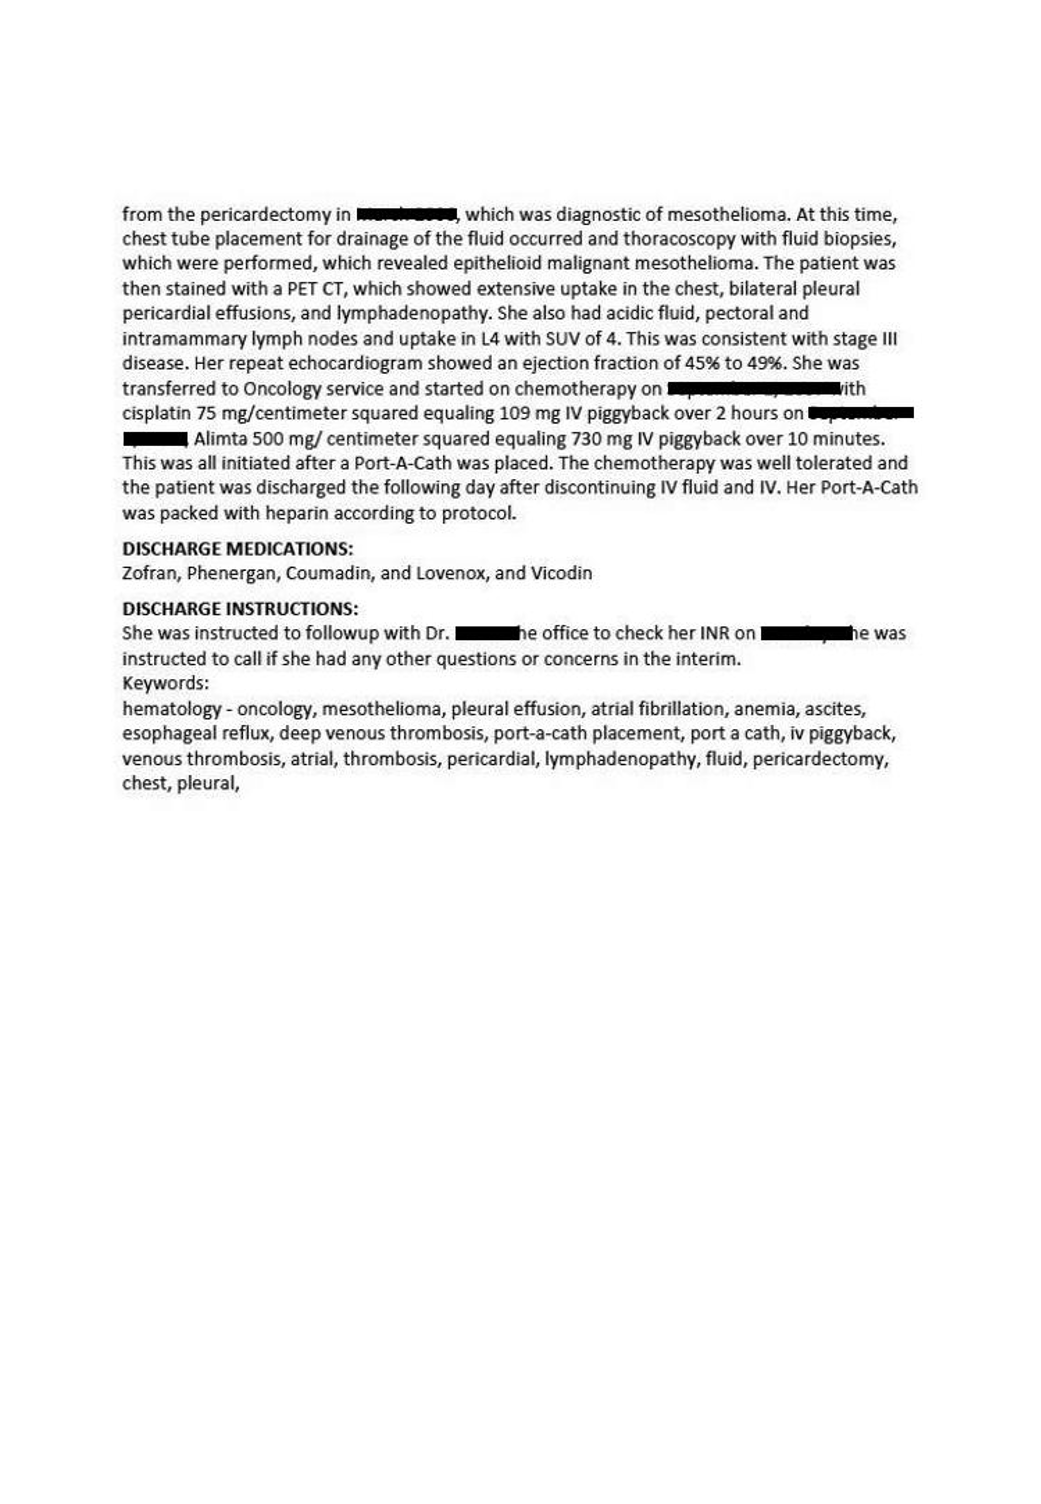


    Image #2:
    Origin: file:/content/de-id/MT_00_compressed.pdf
    Resolution: 100 dpi
    Width: 1041 px
    Height: 1504 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


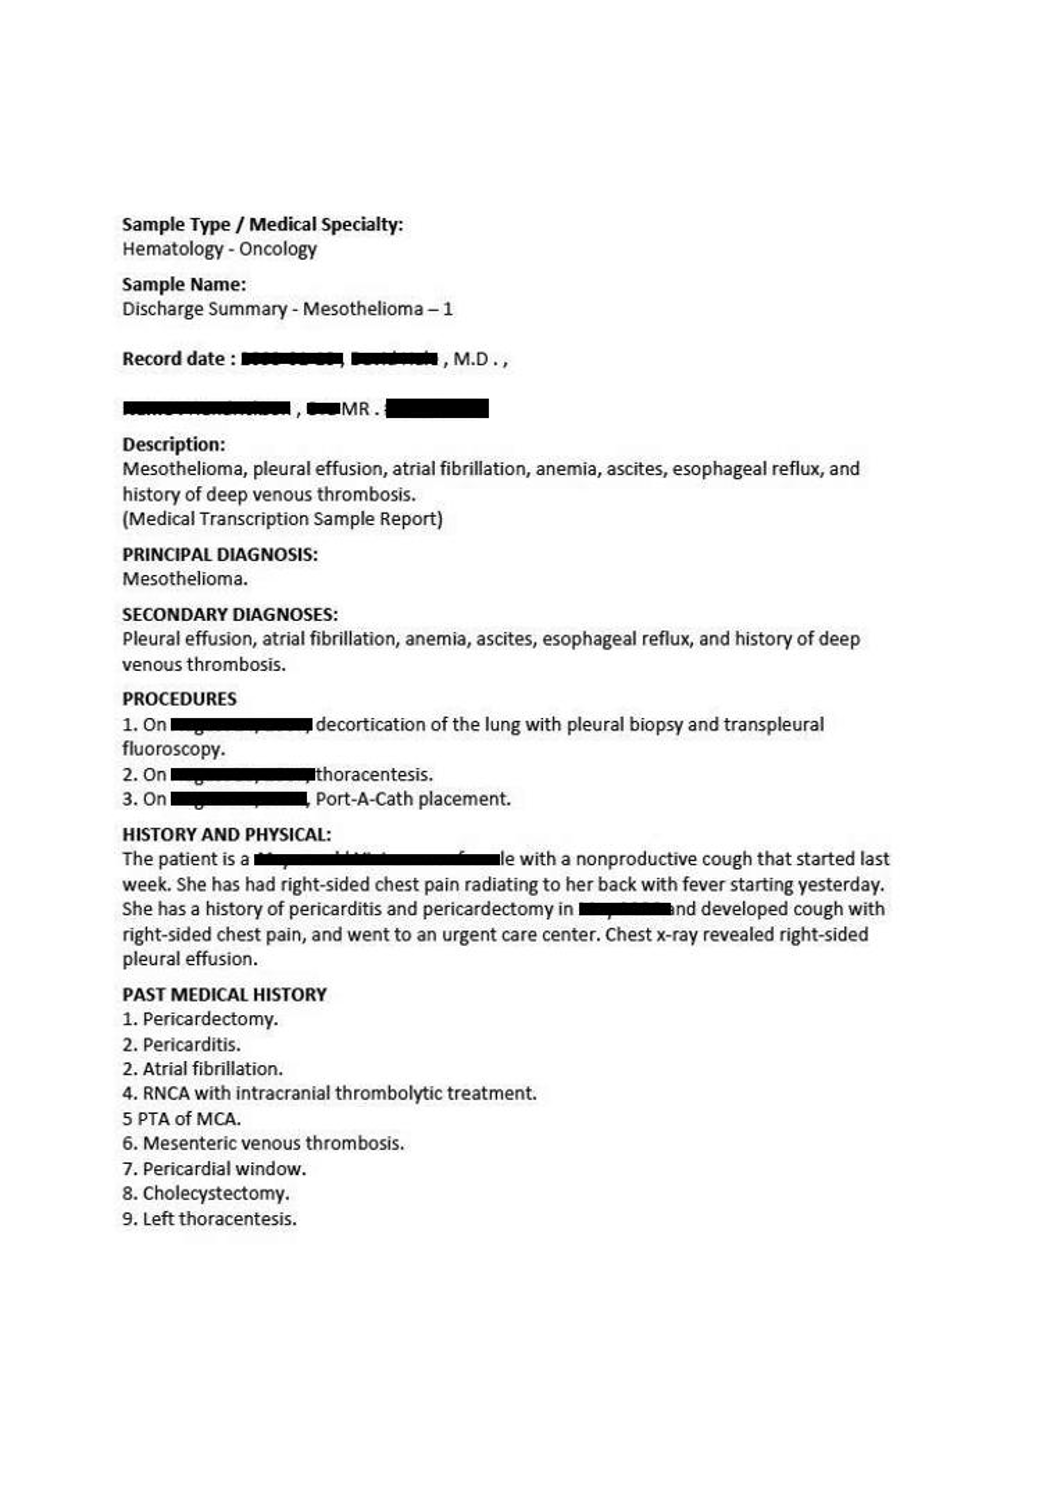

In [10]:
result_pdf_df = spark.read.format("binaryFile").load("./de-id/MT_00_compressed.pdf")
#display_pdf(result_pdf_df)
display_images(pdf_to_image.setResolution(100).transform(result_pdf_df))